In [104]:
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.transforms import NormalizeFeatures
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())

data = dataset[0]


Train Accuracy: 1.0000, Test Accuracy: 0.7200


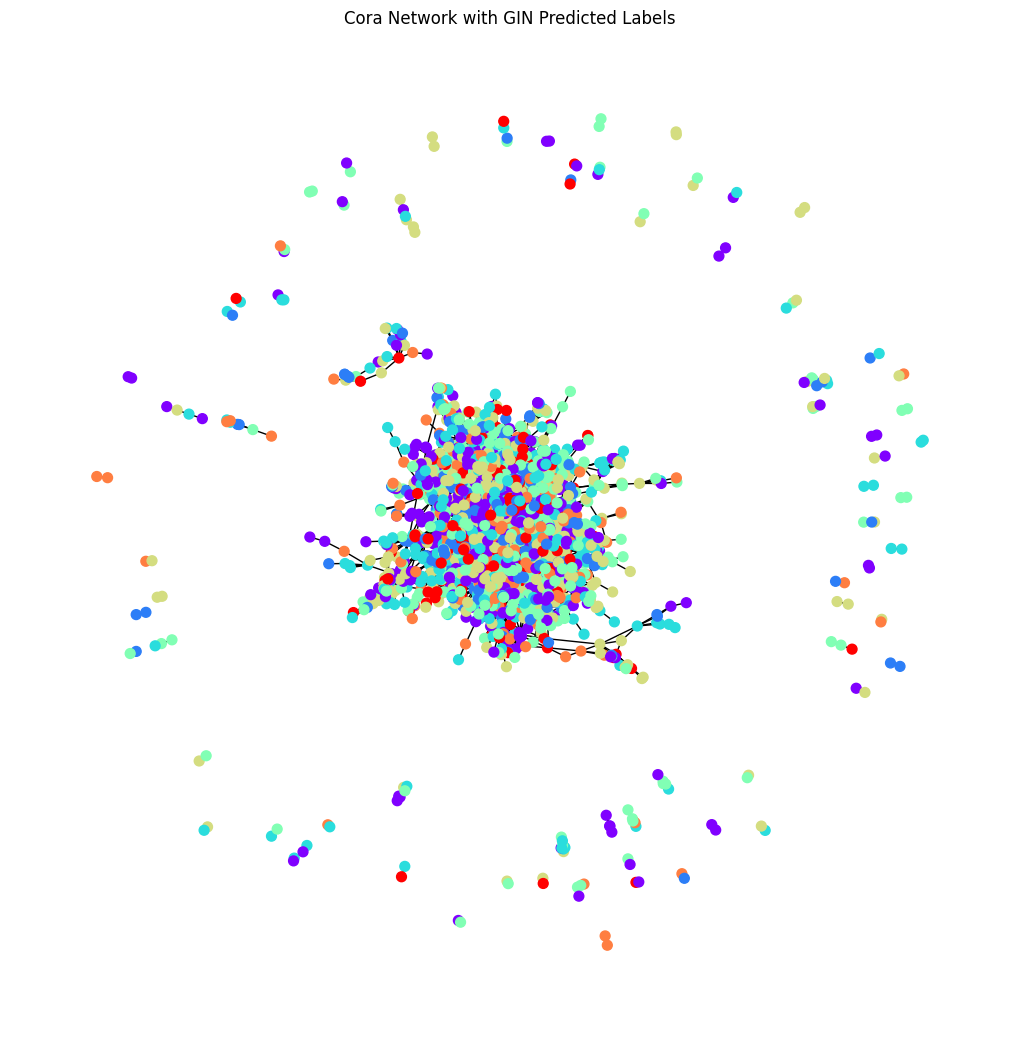

In [105]:
class GIN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GIN, self).__init__()
        self.conv1 = GINConv(torch.nn.Linear(dataset.num_node_features, hidden_channels))
        self.conv2 = GINConv(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lin = torch.nn.Linear(hidden_channels, dataset.num_classes)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.lin(x)

model = GIN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)

train_acc = accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu())
test_acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())

print(f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

G = nx.from_edgelist(data.edge_index.T.cpu().numpy())
plt.figure(figsize=(10, 10))
nx.draw(G, node_color=pred.cpu().numpy(), node_size=50, cmap=plt.cm.rainbow)
plt.title("Cora Network with GIN Predicted Labels")
plt.show()


In [142]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch


imdb_dataset = TUDataset(root='/tmp/IMDB-BINARY', name='IMDB-BINARY')
enzyme_dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

import torch
from torch.utils.data import random_split, DataLoader

imdb_dataset_size = len(imdb_dataset)

train_size_imdb = int(0.7 * imdb_dataset_size)
val_size_imdb = int(0.15 * imdb_dataset_size)
test_size_imdb = imdb_dataset_size - train_size_imdb - val_size_imdb

imdb_train, imdb_val, imdb_test = random_split(imdb_dataset, [train_size_imdb, val_size_imdb, test_size_imdb])

imdb_loader = DataLoader(imdb_train, batch_size=32, shuffle=True, collate_fn=Batch.from_data_list)
imdb_val_loader = DataLoader(imdb_val, batch_size=32, shuffle=False, collate_fn=Batch.from_data_list)
imdb_test_loader = DataLoader(imdb_test, batch_size=32, shuffle=False, collate_fn=Batch.from_data_list)

In [ ]:
import torch
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import degree

class GIN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GIN, self).__init__()
        self.conv1 = GINConv(torch.nn.Linear(1, hidden_channels))
        self.conv2 = GINConv(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lin = torch.nn.Linear(hidden_channels, imdb_dataset.num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)  

    def forward(self, x, edge_index, batch):
        if x is None:
            num_nodes = edge_index.max().item() + 1  
            x = torch.ones((num_nodes, 1))  
        
        x = self.conv1(x, edge_index).relu()
        x = self.dropout(x)  
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)  
        return self.lin(x)


In [ ]:
model = GIN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(200):
    model.train()
    total_loss = 0
    for batch in imdb_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

def evaluate(loader):
    model.eval()
    correct = 0
    for batch in loader:
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = out.argmax(dim=1)
        correct += (pred == batch.y).sum().item()
    return correct / len(loader.dataset)

imdb_acc = evaluate(imdb_loader)

print(f'IMDB Accuracy: {imdb_acc:.4f}')

IMDB Accuracy: 0.6457


In [ ]:
enzyme_loader = DataLoader(enzyme_dataset, batch_size=32, shuffle=True, collate_fn=Batch.from_data_list)

class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class GIN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GIN, self).__init__()
        self.mlp1 = MLP(num_features, hidden_channels, hidden_channels)
        self.mlp2 = MLP(hidden_channels, hidden_channels, hidden_channels)
        
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        
        x = global_mean_pool(x, batch)  
        x = self.fc(x)
        return x

model = GIN(3, 64, 6) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    model.train()
    total_loss = 0
    for batch in enzyme_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)  
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

enzyme_acc = evaluate(enzyme_loader)


In [192]:
enzyme_acc

0.25833333333333336

Regarding the GIN paper:

Describe one thing you found interesting in the reading. Describe what it is in your own words and why you found it interesting.

- I found that a maximally powerful GNN can only be as strong as the WL test fascinating. 

Describe one thing that you found difficult to understand. Try to be specific about what you don’t think you understand.  

Why do the say this is from a countable universe?Why do they need to clarify that?
I don't quite understand how they got the Aggregation function for GIN